In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))

In [2]:
import re
import json
import hydra
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf


import plotly.express as px

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches

from agent.ppo import PPO
from agent.option_critic import OptionCritic

from env.fourrooms import Fourrooms, LTLFourrooms
from env.breakout import Breakout, LTLBreakout, BreakoutNRA
from env.sapientino import Sapientino, LTLSapientino
from env.cartpole import LTLCartPole
from env.acrobot import LTLAcrobot
from env.taxi import LTLTaxi

Device set to : cpu


/opt/conda/envs/uni/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Parameters

In [3]:
PATH = "logs"
DPI = 300

# Monitor

In [16]:
class Monitor:

    def __init__(self, path):
        
        self.path = path
        self.load()

    def load(self):
        
        self.names = os.listdir(self.path)
        self.configs = [json.load(open(os.path.join(PATH, name, "config.json"))) for name in self.names]
        self.configs = pd.json_normalize(self.configs)
        self.configs["name"] = self.names

        self.episode_logs = pd.DataFrame()
        for name in self.names:
            try:
                path = os.path.join(PATH, name, "episode.csv")
                episode_log = pd.read_csv(path)
            except:
                print(name)
                self.configs = self.configs[self.configs.name!=name]
                continue
                
            episode_log["name"] = name
            self.episode_logs = pd.concat([self.episode_logs, episode_log])


    def get_data(self, x, y, color, env, group=[], num_options=None, exp_range=None):

        data = self.configs.merge(self.episode_logs, how="inner", on="name")

        # Generate label
        mask_oc = data["agent.name"]=="OC"
        data.loc[mask_oc, "label"] = data.loc[mask_oc, "agent.num_options"].apply(
            lambda x: f"OC {int(x)} options")

        for label in ["A2C", "PPO"]:
            mask_others = data["agent.name"]==label
            data.loc[mask_others, "label"] = label

        if env:
            data = data[data["env.name"]==env]
        
        if num_options:
            data = data[(data["agent.name"]!="OC")|(data["agent.num_options"]==num_options)].reset_index()

        if exp_range:
            data = data[(data["experiment"]>=exp_range[0])&(data["experiment"]<=exp_range[1])]

        
        
        grouped_data = (
            data.groupby(group + [x], dropna=False)
            .agg({y: ["count", "mean", "min", "max", "std"]})
        )
        grouped_data.columns = grouped_data.columns.droplevel(0)
        grouped_data = grouped_data.reset_index()
    

        return grouped_data
        

    def plot(self, x, y, color, env, 
             group=[], agents=None,
             rolling_mean=None, x_range=None, y_range=None, 
             num_options=None, exp_range=None, dpi=(3, 2)):

        grouped_data = self.get_data(x, y, color, env, group, num_options, exp_range)

        print(grouped_data.shape)
        display(grouped_data.groupby(group).count())

        if "label" in grouped_data:
            display(grouped_data["label"].value_counts())

        if rolling_mean:
            grouped_data["mean"] = (
                grouped_data.groupby(group, dropna=False)["mean"].rolling(window=rolling_mean).mean().values
            )

        if agents and "label" in grouped_data:
            grouped_data = grouped_data[grouped_data["label"].isin(agents)]
        elif agents:
            grouped_data = grouped_data[grouped_data["agent.name"].isin(agents)]
        
        fig = px.line(
            data_frame=grouped_data,
            x=x,
            y="mean",
            color=color,
            labels={
                x: "Episode",
                "mean": "Reward",
            },
            template="ggplot2",
            width=dpi[0]*DPI, height=dpi[1]*DPI,
        )
        fig.update_layout(
            legend=dict(
                title= {'text': None},
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            ),
            font=dict(size=20)
        )

        if x_range: fig.update_layout(xaxis_range=x_range)
        if y_range: fig.update_layout(yaxis_range=y_range)

        fig.layout.xaxis.rangemode: 'tozero'
        fig.layout.yaxis.rangemode: 'tozero'
        
        return fig
    
monitor = Monitor(PATH)
monitor.configs.groupby(["env.name", "agent.name", "agent.num_options"], dropna=False)["experiment"].count().to_frame()

experiment
env.name    agent.name    agent.num_options            
Acrobot-v1  OC            8.0                         1
            PPO           NaN                         1
CartPole-v1 OC            4.0                        10
            PPO           NaN                         3
LTLacrobot  OC            4.0                        10
                          8.0                        10
            PPO           NaN                         1
LTLcartpole OC            4.0                        10
                          8.0                        10
            PPO           NaN                        10
LTLtaxi     OC            4.0                        10
                          8.0                        10
            PPO           NaN                        10
breakout    OC            4.0                        20
                          8.0                        20
                          16.0                       10
            PPO           NaN                        10
            Tabular_Sarsa NaN                        10
breakoutNRA OC            8.0                        10
            PPO           NaN                        10
            Tabular_Sarsa NaN                        10
fourrooms   A2C           NaN                        20
            OC            4.0                        10
                          8.0                        10
            PPO           NaN                         5
sapientino  OC            8.0                        19
            PPO           NaN                         9
            Tabular_Sarsa NaN                        10

# Sapientino

In [13]:
fig = monitor.plot(
    x="episode", y="reward", color="label", env="sapientino", 
    agents=["PPO", "OC 8 options"],
    group=["env.name", "label"], rolling_mean=50, x_range=[0, 10000], y_range=[0, 2000])
fig.write_image('sapientino_curves.png')

(150001, 8)


episode   count    mean     min     max    std
env.name   label                                                       
sapientino OC 8 options    30000   30000   30000   30000   30000  30000
           PPO            100000  100000  100000  100000  100000  20000

PPO             100000
OC 8 options     30000
Name: label, dtype: int64

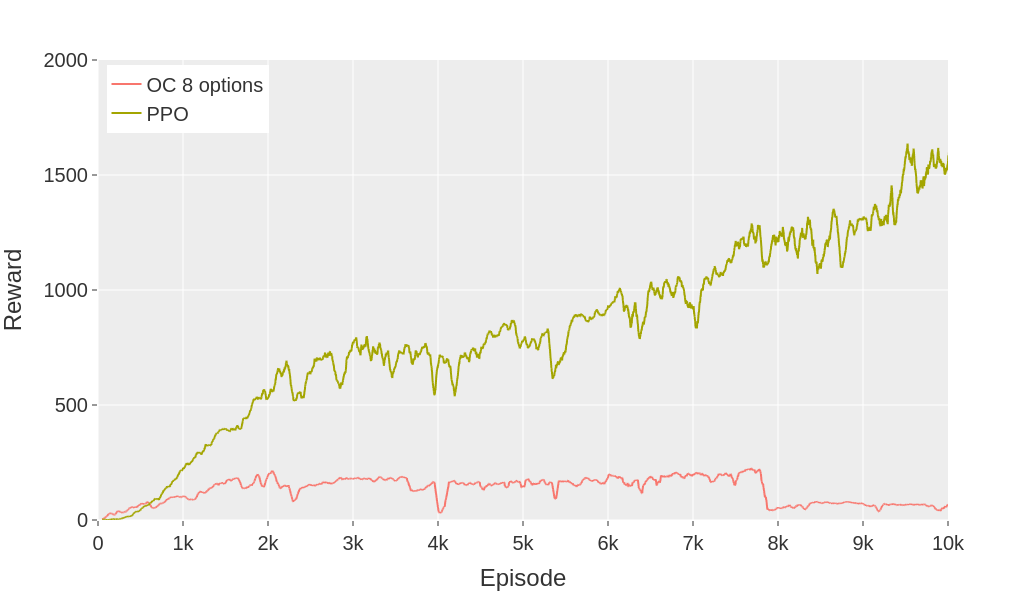

In [14]:
fig

# Breakout
## Breakout Modified

In [17]:
fig = monitor.plot(x="episode", y="reward", color="label", env="breakout", 
                   group=["env.name", "label"], 
                   agents=["PPO", "OC 8 options"],
                   rolling_mean=50, x_range=[0, 3000], num_options=8, 
                   exp_range=(1, 10), dpi=(3,2))
fig.write_image('breakout_curves.png')

(15001, 8)


episode  count  mean   min   max   std
env.name label                                               
breakout OC 8 options     6000   6000  6000  6000  6000  6000
         PPO              6000   6000  6000  6000  6000  6000

OC 8 options    6000
PPO             6000
Name: label, dtype: int64

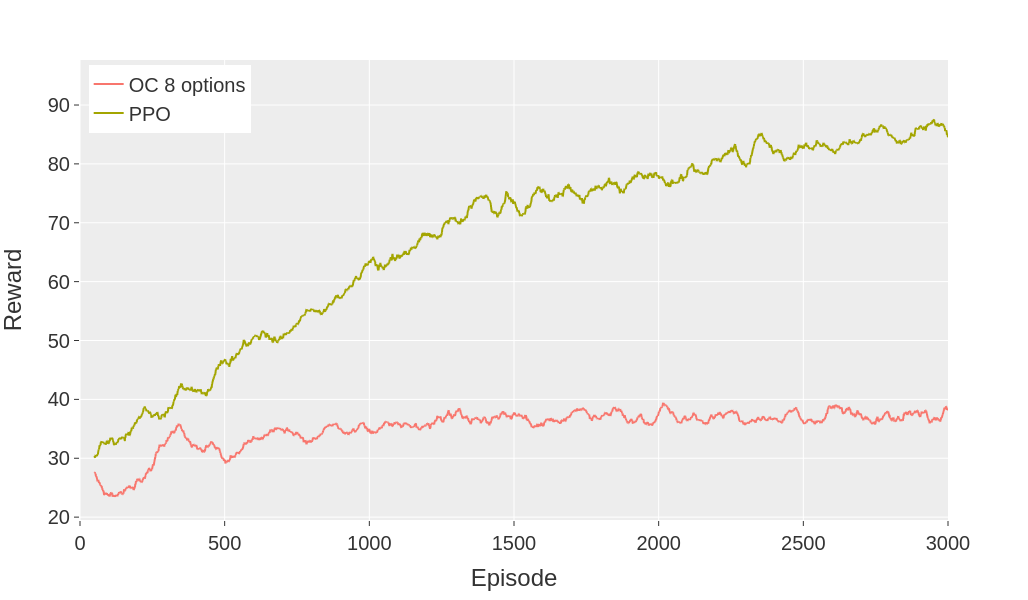

In [18]:
fig

# Fourrroms
## Curves

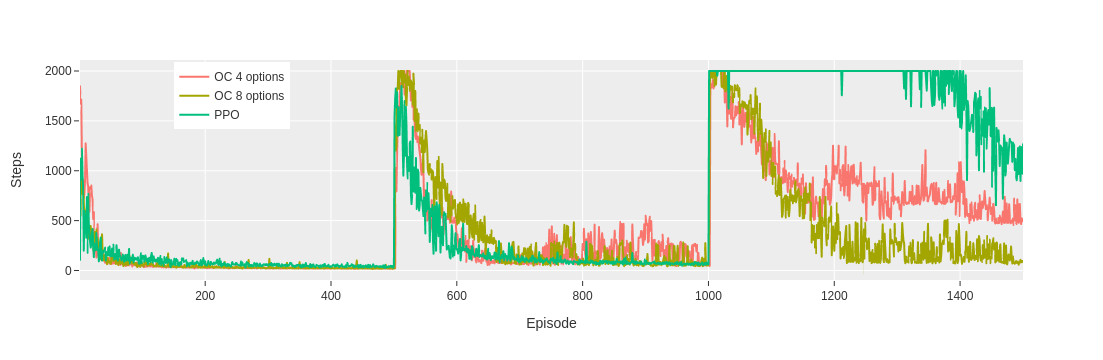

In [14]:
fourrooms_data = monitor.get_data(x="episode", y="ep_steps", color="agent.name", env="fourrooms", 
             group=["env.name", "agent.name", "agent.num_options"])

x_range = None
x = "episode"
group = ["env.name", "agent.name", "agent.num_options"]
rolling_mean = 1

intervale_newspec = [pd.cut(fourrooms_data["episode"], np.arange(1, 1500+500, 500))]
n = fourrooms_data["agent.name"].unique().shape[0]

fourrooms_data.loc[n+1:, "mean"] = (
    fourrooms_data.groupby(group + intervale_newspec, dropna=False)["mean"]
    .rolling(window=rolling_mean, min_periods=1).mean().values
)

mask_oc = fourrooms_data["agent.name"]=="OC"
fourrooms_data.loc[mask_oc, "label"] = fourrooms_data.loc[mask_oc, "agent.num_options"].apply(
    lambda x: f"OC {int(x)} options")

for label in ["A2C", "PPO"]:
    mask_a2c = fourrooms_data["agent.name"]==label
    fourrooms_data.loc[mask_a2c, "label"] = label

fourrooms_data = fourrooms_data[fourrooms_data["agent.name"].isin(["PPO", "OC"])]

fig = px.line(
    data_frame=fourrooms_data,
    x=x,
    y="mean",
    color="label",
    labels={
        x: "Episode",
        "mean": "Steps",
    },
    template="ggplot2",
    width=3*DPI, height=1.2*DPI,
)
fig.update_layout(
    legend=dict(
        title= {'text': None},
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.10
))

if x_range: fig.update_layout(xaxis_range=x_range)
    
fig.show()
fig.write_image("HRL_3pointroute2.png")

## Primary Policy
### Individual Curves

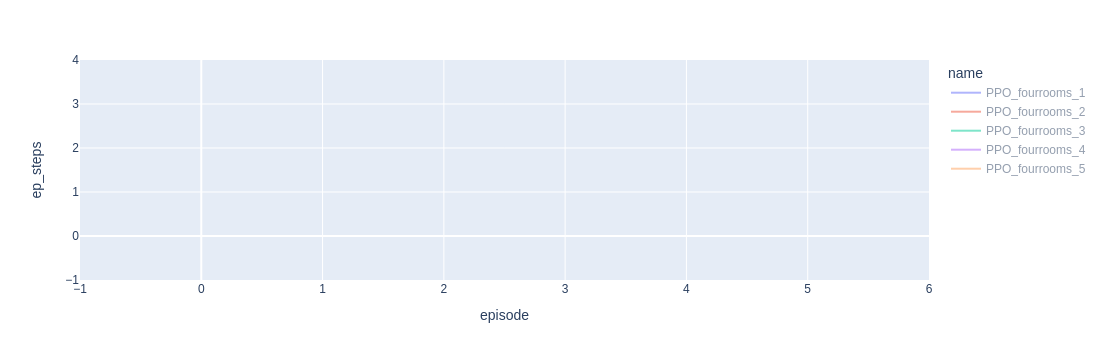

In [15]:
rolling_mean = 1
data = monitor.configs.merge(monitor.episode_logs, how="inner", on="name")
data = data[data["env.name"]=="fourrooms"]
# data = data[data["episode"]>1000]
grouped_data = (
    data.groupby(["name", "agent.name", "agent.num_options", "episode"], dropna=False)["ep_steps"]
    .rolling(window=rolling_mean, min_periods=1).mean()
    .reset_index()
)
fig = px.line(grouped_data[grouped_data["agent.num_options"]==4], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
# fig.show()

fig = px.line(grouped_data[grouped_data["agent.num_options"]==8], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
# fig.show()

fig = px.line(grouped_data[grouped_data["agent.name"]=="A2C"], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
# fig.show()

fig = px.line(grouped_data[grouped_data["agent.name"]=="PPO"], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
# fig.show()

## Main Policy Environment

/tmp/ipykernel_1487/4055283716.py:62: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/crarojasca/Storage/Monash/HRL_LTL_Goals/code/agent/option_critic.py:96: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_1487/4055283716.py:95: UserWarning:

The figure layout has changed to tight



[<matplotlib.patches.Patch object at 0x7fde07243a30>, <matplotlib.patches.Patch object at 0x7fdd93a23190>, <matplotlib.patches.Patch object at 0x7fdd93a23250>, <matplotlib.patches.Patch object at 0x7fdd93a233a0>]


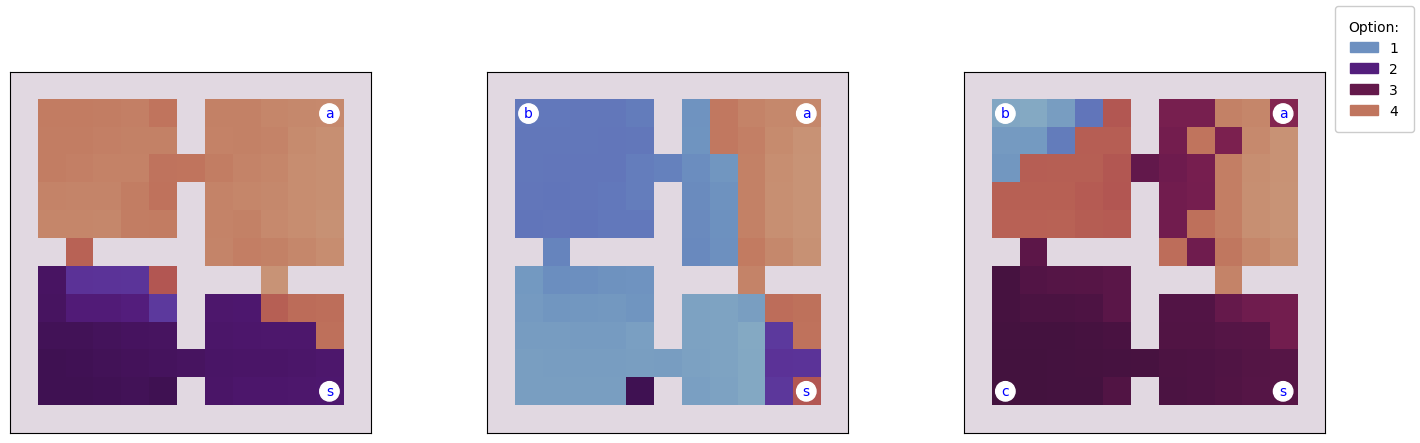

In [16]:
env_states = 104
env_spec = 3
inter = 0.25 # Space between range of colors
color_pallete = mpl.colormaps["twilight"]
labels = ["s", "a", "b", "c"]
diffuse = True

model = torch.load("models/OC_fourrooms_1_4opt_ThirdStage")
cfg = OmegaConf.create(model["hyperparameters"])
env = LTLFourrooms(**cfg.env)
agent = OptionCritic(
        observation_space=env.observation_space, 
        action_space=env.action_space.n,
        args=cfg.agent
)
agent.option_critic.load_state_dict(model['model_params'])

handles = []
colors = []
for option_idx in range(cfg.agent.num_options):
    # Create handle: legend by option
    color = color_pallete((option_idx+1)/(cfg.agent.num_options + 1))
    colors.append(color)
    handle = patches.Patch(color=color, label=option_idx+1)
    handles.append(handle)

def plot_main_policy():
    fig, axs = plt.subplots(1, env_spec, figsize=(15, 5), layout='constrained')    
                
    for spec_idx in range(env_spec):
    
        # Adding the goals of the LTL spec
        for goal_idx in range(spec_idx+1):
            goal_label = re.match("x(.*?)y(.*)", env.spec.route[goal_idx])
            goal_cords = int(goal_label.group(1)), int(goal_label.group(2))
    
    
            circle = patches.Circle(goal_cords, radius=0.35, color='w')
            axs[spec_idx].add_patch(circle)
    
            axs[spec_idx].annotate(labels[goal_idx+1], goal_cords, color='b', 
                    fontsize=10, ha='center', va='center')
    
        # Adding the start position
        initial_location = env.tocell[env.init_states[0]]
        circle = patches.Circle(initial_location, radius=0.35, color='w')
        axs[spec_idx].add_patch(circle)
    
        axs[spec_idx].annotate("s", initial_location, color='b',
                fontsize=10, ha='center', va='center')
        
        map = env.occupancy.copy()*(cfg.agent.num_options + 1)
        map = map.astype(float)
    
        # Getting the values for the matrix for each state
        for env_idx in range(env_states):
            obs = torch.zeros(env.observation_space.shape[0])
            
            obs[env_idx] = 1
            obs[env_states+spec_idx]=1
    
            obs = torch.tensor(obs, dtype=torch.float32).to(agent.device)
            state = agent.option_critic.get_state(obs)
            logits = agent.option_critic.Q(obs)
            probs = logits.softmax(dim=-1)
            prob = probs.max()
            option = probs.argmax(dim=-1)
            
            # greedy_option  = agent.option_critic.greedy_option(state)
        #     action, logp, entropy = option_critic.get_action(state, greedy_option)
    
            pos = list(env.tocell[env_idx])
            map[pos[0], pos[1]] =  (option + prob + 1).item()
    
        #  Diffuse color for each option
        for option_idx in range(cfg.agent.num_options):
    
            # Create diffuse color
            if diffuse:
                mask = np.where((map>=option_idx+1) & (map<option_idx+2))
                if map[mask].size != 0:
                    max_ = map[mask].max()
                    min_ = map[mask].min()
                    slope = 2*inter/(max_-min_)
                    map[mask] = map[mask]*slope#
                    map[mask] = map[mask]-map[mask].min()
                    map[mask] = map[mask] + option_idx + 1 - inter # 0.25
            
        # Plot Grid
        matrice = axs[spec_idx].matshow(map, vmin=-0, vmax=cfg.agent.num_options + 1, cmap=color_pallete)
        axs[spec_idx].tick_params(left = False, bottom = False, top=False)
        axs[spec_idx].set_yticklabels([])
        axs[spec_idx].set_xticklabels([])
    
    fig.tight_layout(pad=5.0)
    print(handles)
    fig.legend(handles=handles, fancybox=True, framealpha=1, borderpad=1, loc="outside right upper", title="Option:")
    plt.savefig('options_activation.png')

plot_main_policy()

## Best scores final policy

In [51]:
def eval_model(name):

    envs = {
        "fourrooms": LTLFourrooms,
        "breakout": LTLBreakout,
        "breakoutNRA": BreakoutNRA,
        "sapientino": LTLSapientino,
        "LTLcartpole": LTLCartPole,
        "LTLacrobot": LTLAcrobot,
        "LTLtaxi": LTLTaxi,
    }
    
    model = torch.load(f"models/{name}")
    cfg = OmegaConf.create(model["hyperparameters"])
    env = envs[cfg.env.name](**cfg.env)
    agent = OptionCritic(
            observation_space=env.observation_space, 
            action_space=env.action_space.n,
            args=cfg.agent
    )
    agent.option_critic.load_state_dict(model['model_params'])
    
    res = env.reset()

    if isinstance(res, tuple):
        obs, info = res
    else:
        obs = res
    
    state = agent.option_critic.get_state(obs)
    greedy_option  = agent.option_critic.greedy_option(state)
    
    current_option = 0
    curr_op_len = 0
    ep_steps = 0
    ep_reward = 0
    option_termination = True
    epsilon = 0
    done = False
    truncated = False
    max_steps = 200
    
    option_trace = []
    spec_trace = []    

    
    
    while not(done or truncated or ep_steps>max_steps):
        
        if option_termination:
            current_option = np.random.choice(agent.num_options) if np.random.rand() < epsilon else greedy_option
    
        # ACTION
        action, logp, entropy, probs = agent.option_critic.get_action(state, current_option)
    
        # STEP
        res = env.step(action)

        if len(res)==4:
            next_obs, reward, done, _ = res
        else:
            next_obs, reward, done, truncated, _ = res
            
        ep_reward += reward 
    
        # NEXT STATE
        state = agent.option_critic.get_state(next_obs)
    
        # OPTION TERMINATION
        option_termination, greedy_option = agent.option_critic.predict_option_termination(
            state, current_option)
        
        ep_steps += 1
        curr_op_len += 1
        obs = next_obs
        option_trace.append(current_option+1)
        spec_trace.append(env.spec.state)

    print("{}, Options: {}, Num Options: {}, Ep Steps: {}, Reward: {}".format(
        name, pd.Series(option_trace).unique(), agent.option_critic.num_options, ep_steps, reward))
    log = pd.DataFrame({"option_trace": option_trace, "spec_trace": spec_trace})
    return log

eval_data = pd.DataFrame()
names = monitor.configs[(monitor.configs["env.name"]=="fourrooms")&(monitor.configs["agent.name"]=="OC")].name.unique()

for name in names:
    eval_log = eval_model(name+"_ThirdStage")
    eval_log["name"] = name
    eval_data = pd.concat([eval_data, eval_log])

eval_data.groupby(["name"])["option_trace"].count().sort_values()

OC_fourrooms_5_4opt_ThirdStage, Options: [2 4 1], Num Options: 4, Ep Steps: 50, Reward: 1
OC_fourrooms_1_4opt_ThirdStage, Options: [2 1], Num Options: 4, Ep Steps: 201, Reward: 0
OC_fourrooms_10_8opt_ThirdStage, Options: [7 1 8], Num Options: 8, Ep Steps: 84, Reward: 1
OC_fourrooms_1_8opt_ThirdStage, Options: [4 5 8], Num Options: 8, Ep Steps: 81, Reward: 1
OC_fourrooms_4_8opt_ThirdStage, Options: [4 2 3], Num Options: 8, Ep Steps: 164, Reward: 1
OC_fourrooms_9_4opt_ThirdStage, Options: [2 3 4], Num Options: 4, Ep Steps: 186, Reward: 1
OC_fourrooms_9_8opt_ThirdStage, Options: [1 7 8 5], Num Options: 8, Ep Steps: 70, Reward: 1
OC_fourrooms_3_4opt_ThirdStage, Options: [1 3 2], Num Options: 4, Ep Steps: 81, Reward: 1
OC_fourrooms_5_8opt_ThirdStage, Options: [4 8 6], Num Options: 8, Ep Steps: 67, Reward: 1
OC_fourrooms_6_4opt_ThirdStage, Options: [3 1], Num Options: 4, Ep Steps: 117, Reward: 1
OC_fourrooms_7_4opt_ThirdStage, Options: [1 4 3], Num Options: 4, Ep Steps: 78, Reward: 1
OC_four

name
OC_fourrooms_3_8opt      49
OC_fourrooms_2_4opt      50
OC_fourrooms_2_8opt      50
OC_fourrooms_4_4opt      50
OC_fourrooms_5_4opt      50
OC_fourrooms_7_8opt      56
OC_fourrooms_6_8opt      58
OC_fourrooms_5_8opt      67
OC_fourrooms_9_8opt      70
OC_fourrooms_7_4opt      78
OC_fourrooms_1_8opt      81
OC_fourrooms_3_4opt      81
OC_fourrooms_10_8opt     84
OC_fourrooms_10_4opt     87
OC_fourrooms_6_4opt     117
OC_fourrooms_4_8opt     164
OC_fourrooms_9_4opt     186
OC_fourrooms_8_8opt     187
OC_fourrooms_1_4opt     201
OC_fourrooms_8_4opt     201
Name: option_trace, dtype: int64

## Spec Options Timeline

In [18]:
def get_partitions(trace):
    # Paritions traces 00001111122223333
    
    current = trace[0]
    start = 0
    
    partitions = pd.DataFrame()
    for i, value in enumerate(trace):
        if value!=current or i==len(trace)-1:   
            partition = pd.DataFrame([{"option": str(current), "start": start+1, "end": i, "duration": i-start}])
            partitions = pd.concat([partitions, partition])
            
            start = i
            current = value

    partitions = partitions.reset_index(drop=True)
    return partitions

option  start   end  duration
0      1    NaN   NaN       NaN
1      2   30.0  33.0       4.0
2      3   34.0  52.0      19.0
3      4    1.0  29.0      29.0
4      5    NaN   NaN       NaN
5      6    NaN   NaN       NaN
6      7    NaN   NaN       NaN
7      8    NaN   NaN       NaN

option  start  end  duration
0      0      1   11        11
1      1     12   32        21
2      2     33   52        20

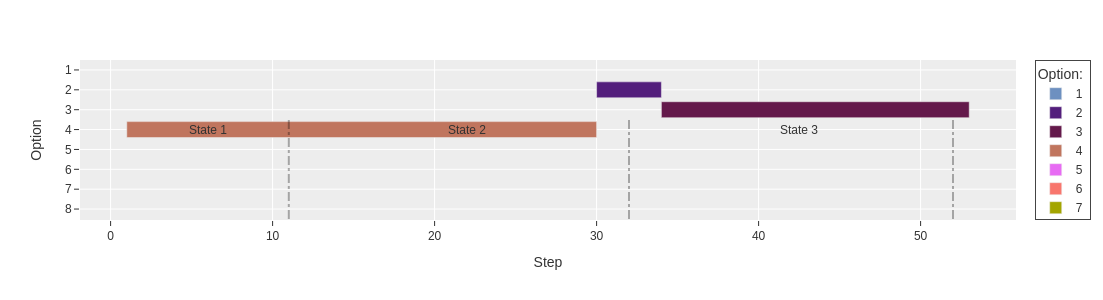

In [19]:
def graph_timeline(name, num_options):
    # PARTITION OPTIONS
    options_trace = eval_data[eval_data["name"]==name]["option_trace"]
    options_partitions = get_partitions(options_trace)
    ## Fill for empty options
    options_partitions = (
        options_partitions.sort_values("option").set_index("option")
        .reindex(list(map(str, range(1, num_options+1)))).reset_index()
    )
    display(options_partitions)
    
    # PARTITION SPEC STATE
    spec_trace = eval_data[eval_data["name"]==name]["spec_trace"]
    spec_partitions = get_partitions(spec_trace)
    display(spec_partitions)
    
    fig = px.bar(
        options_partitions, base="start", x="duration", y="option", orientation='h', color="option",
        color_discrete_map = {str(i+1): matplotlib.colors.to_hex(colors[i]) for i in range(len(colors))},
        labels={"option":"Option", "duration": "Step"},
        template="ggplot2",
        width=3.5*DPI, height=1*DPI
    )
    
    text_cords = []
    spec_text = [] 
    for i, spec_idx in spec_partitions.iterrows():
        
        fig.add_shape(
            type="line",
            x0=spec_idx["end"], y0=-0.5, x1=spec_idx["end"], y1=4.5,
            line=dict(
                color="black",
                width=2,
                dash="dashdot",
            )
        )
    
        cord = (spec_idx["end"]-spec_idx["start"])/2 + spec_idx["start"]
        fig.add_annotation(
                x=cord, y=4,
                text=f"State {i + 1}",
                showarrow=False,
                          )
        text_cords.append(cord)
        spec_text.append(f"State {i + 1}")
    
    
    fig.update_layout(
        legend=dict(
            title= {'text': "Option: "},
            borderwidth=1,
            # x=0.94,
            # y=0.54,
            yanchor="top",
            xanchor="left",  
            # font=dict(
            #     family="Courier",
            #     size=12,
            #     color="black"
            # ),
    ))
    
    return fig

# name = "OC_fourrooms_5_4opt"
name = "OC_fourrooms_6_8opt"
fig = graph_timeline(name, 8)

fig.write_image('options_timeline.png')
fig.show()

# CartPole

(6000, 8)


OC 4 options    2000
OC 8 options    2000
PPO             2000
Name: label, dtype: int64

episode  count  mean   min   max   std
env.name    label                                               
LTLcartpole OC 4 options     2000   2000  2000  2000  2000  2000
            OC 8 options     2000   2000  2000  2000  2000  2000
            PPO              2000   2000  2000  2000  2000  2000

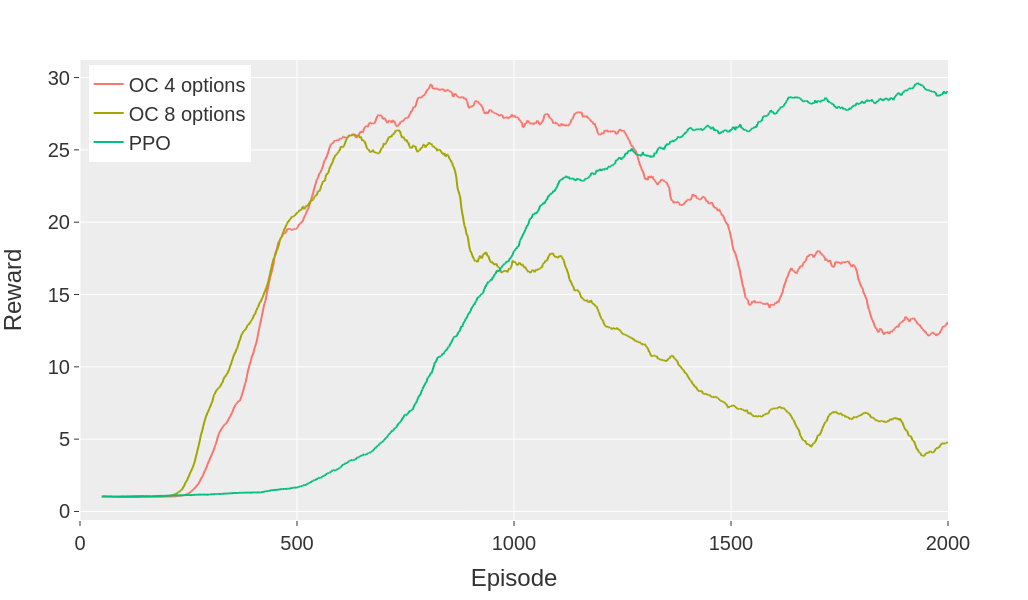

In [64]:
fig = monitor.plot(x="episode", y="reward", color="label", env="LTLcartpole", 
                   group=["env.name", "label"], 
                   rolling_mean=50, x_range=[0, 2000], exp_range=(1, 10), dpi=(2,2))
fig.write_image('CartPole_curves.png')
fig  

OC_LTLcartpole_2_8opt, Options: [5 1 6 7 8], Num Options: 8, Ep Steps: 167, Reward: 0
OC_LTLcartpole_7_8opt, Options: [4 2 1 8 5 6], Num Options: 8, Ep Steps: 201, Reward: 0
OC_LTLcartpole_9_8opt, Options: [3 6 2 4], Num Options: 8, Ep Steps: 27, Reward: 0
OC_LTLcartpole_6_8opt, Options: [4 2 7 3 1 5 6], Num Options: 8, Ep Steps: 128, Reward: 0
OC_LTLcartpole_10_8opt, Options: [3 5 6 2 4 7], Num Options: 8, Ep Steps: 201, Reward: 0
OC_LTLcartpole_3_4opt, Options: [3 2 4 1], Num Options: 4, Ep Steps: 201, Reward: 0
OC_LTLcartpole_9_4opt, Options: [4 1 3 2], Num Options: 4, Ep Steps: 184, Reward: 0
OC_LTLcartpole_6_4opt, Options: [1 4 3 2], Num Options: 4, Ep Steps: 201, Reward: 0
OC_LTLcartpole_5_8opt, Options: [1 2 6 7 3 5 8], Num Options: 8, Ep Steps: 201, Reward: 0
OC_LTLcartpole_2_4opt, Options: [1 3 4 2], Num Options: 4, Ep Steps: 201, Reward: 0
OC_LTLcartpole_4_8opt, Options: [3 2 1 8 5], Num Options: 8, Ep Steps: 136, Reward: 0
OC_LTLcartpole_5_4opt, Options: [3 2 4 1], Num Optio

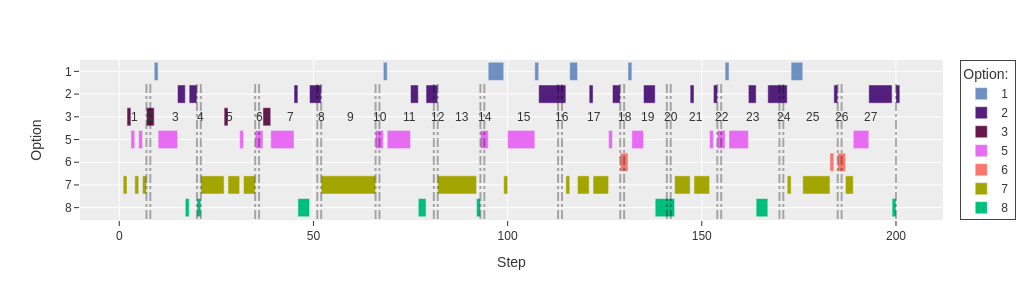

In [61]:
eval_data = pd.DataFrame()
names = monitor.configs[(monitor.configs["env.name"]=="LTLcartpole")&(monitor.configs["agent.name"]=="OC")].name.unique()

for name in names:
    eval_log = eval_model(name)
    eval_log["name"] = name
    eval_data = pd.concat([eval_data, eval_log])

name = "OC_LTLcartpole_1_8opt"
# PARTITION OPTIONS
options_trace = eval_data[eval_data["name"]==name]["option_trace"]
options_partitions = get_partitions(options_trace)
## Fill for empty options
options_partitions = (
    options_partitions.sort_values("option")
    # .set_index("option")
    # .reindex(list(map(str, range(1, 8+1))))
    .reset_index()
)
# display(options_partitions)

# PARTITION SPEC STATE
spec_trace = eval_data[eval_data["name"]==name]["spec_trace"]
spec_partitions = get_partitions(spec_trace)
# display(spec_partitions)

fig = px.bar(
    options_partitions, base="start", x="duration", y="option", orientation='h', color="option",
    color_discrete_map = {str(i+1): matplotlib.colors.to_hex(colors[i]) for i in range(len(colors))},
    labels={"option":"Option", "duration": "Step"},
    template="ggplot2",
    width=3.5*DPI, height=1*DPI
)

text_cords = []
spec_text = [] 
for i, spec_idx in spec_partitions.iterrows():

    
    fig.add_shape(
        type="line",
        x0=spec_idx["end"], y0=-0.5, x1=spec_idx["end"], y1=5.5,
        line=dict(
            color="black",
            width=2,
            dash="dashdot",
        )
    )

    cord = (spec_idx["end"]-spec_idx["start"])/2 + spec_idx["start"]
    fig.add_annotation(
            x=cord, y=4,
            text=f"{i + 1}",
            showarrow=False,
                      )
    text_cords.append(cord)
    spec_text.append(f"State {i + 1}")


fig.update_layout(
    legend=dict(
        title= {'text': "Option: "},
        borderwidth=1,
        # x=0.94,
        # y=0.54,
        yanchor="top",
        xanchor="left",  
        # font=dict(
        #     family="Courier",
        #     size=12,
        #     color="black"
        # ),
))

# Acrobot

(5000, 8)


OC 4 options    2000
OC 8 options    2000
PPO             1000
Name: label, dtype: int64

episode  count  mean   min   max   std
env.name   label                                               
LTLacrobot OC 4 options     2000   2000  2000  2000  2000  2000
           OC 8 options     2000   2000  2000  2000  2000  2000
           PPO              1000   1000  1000  1000  1000     0

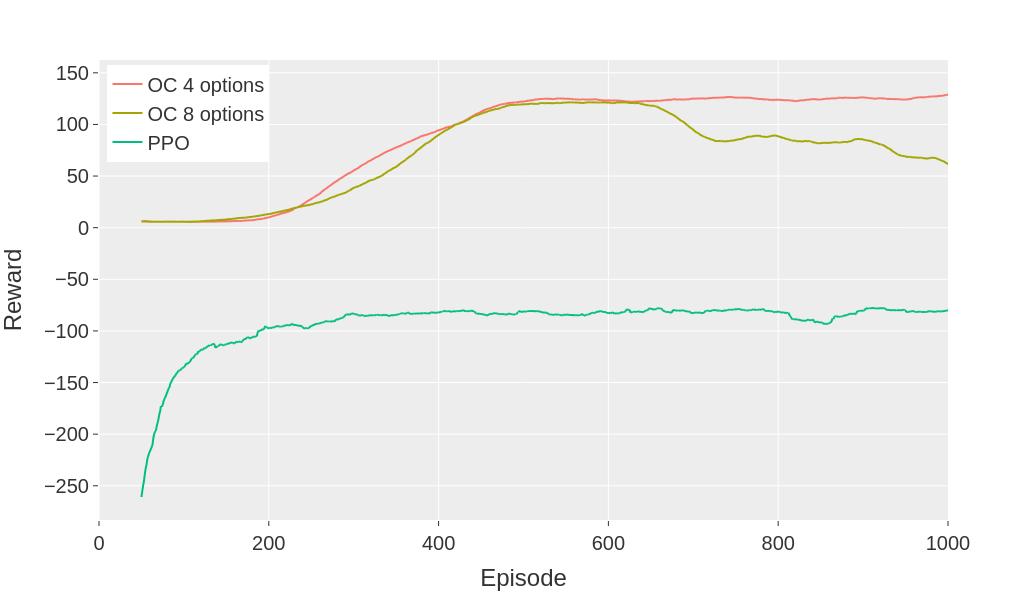

In [72]:
fig = monitor.plot(x="episode", y="reward", color="label", env="LTLacrobot", 
                   group=["env.name", "label"], 
                   rolling_mean=50, x_range=[0, 1000], exp_range=(1, 10), dpi=(2,2))
fig.write_image('Acrobot_curves.png')
fig

In [24]:
eval_data = pd.DataFrame()
names = monitor.configs[(monitor.configs["env.name"]=="LTLacrobot")&(monitor.configs["agent.name"]=="OC")].name.unique()

for name in names:
    eval_log = eval_model(name)
    eval_log["name"] = name
    eval_data = pd.concat([eval_data, eval_log])

OC_LTLacrobot_3_8opt [8 1 5 3 4 7] 8 93
OC_LTLacrobot_7_8opt [2 1 8 4 5 7 3 6] 8 89
OC_LTLacrobot_8_8opt [8 6 7 2 4 1 3] 8 70
OC_LTLacrobot_6_8opt [2 8 6 1 4 7 3 5] 8 88
OC_LTLacrobot_4_8opt [3 7 2 8 5 1 4 6] 8 193
OC_LTLacrobot_2_8opt [3 6 2 1 5 7 4] 8 78
OC_LTLacrobot_5_8opt [1 2 4 5 3 7 6 8] 8 87
OC_LTLacrobot_9_8opt [7 6 8 4 1 3 2 5] 8 93
OC_LTLacrobot_1_8opt [7 3 1 5 4 8 6] 8 81
OC_LTLacrobot_10_8opt [1 7 6 3 4 2 5 8] 8 82


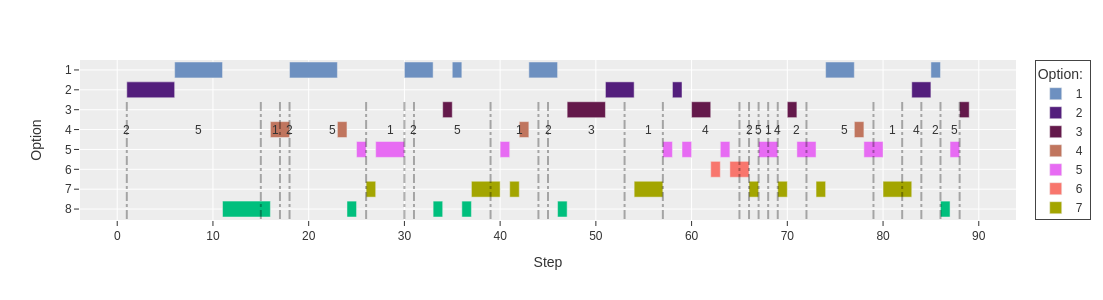

In [25]:
name = "OC_LTLacrobot_7_8opt"
# PARTITION OPTIONS
options_trace = eval_data[eval_data["name"]==name]["option_trace"]
options_partitions = get_partitions(options_trace)
## Fill for empty options
options_partitions = (
    options_partitions.sort_values("option")
    # .set_index("option")
    # .reindex(list(map(str, range(1, 8+1))))
    .reset_index()
)
# display(options_partitions)

# PARTITION SPEC STATE
spec_trace = eval_data[eval_data["name"]==name]["spec_trace"]
spec_partitions = get_partitions(spec_trace)
# display(spec_partitions)

fig = px.bar(
    options_partitions, base="start", x="duration", y="option", orientation='h', color="option",
    color_discrete_map = {str(i+1): matplotlib.colors.to_hex(colors[i]) for i in range(len(colors))},
    labels={"option":"Option", "duration": "Step"},
    template="ggplot2",
    width=3.5*DPI, height=1*DPI
)

text_cords = []
spec_text = [] 
for i, spec_idx in spec_partitions.iterrows():

    
    fig.add_shape(
        type="line",
        x0=spec_idx["end"], y0=-0.5, x1=spec_idx["end"], y1=5.5,
        line=dict(
            color="black",
            width=2,
            dash="dashdot",
        )
    )

    cord = (spec_idx["end"]-spec_idx["start"])/2 + spec_idx["start"]
    fig.add_annotation(
            x=cord, y=4,
            text=int(spec_idx["option"]) + 1,
            showarrow=False,
                      )
    text_cords.append(cord)
    spec_text.append(f"State {i + 1}")


fig.update_layout(
    legend=dict(
        title= {'text': "Option: "},
        borderwidth=1,
        # x=0.94,
        # y=0.54,
        yanchor="top",
        xanchor="left",  
        # font=dict(
        #     family="Courier",
        #     size=12,
        #     color="black"
        # ),
))

# Taxi

(3000, 8)


OC 4 options    1000
OC 8 options    1000
PPO             1000
Name: label, dtype: int64

episode  count  mean   min   max   std
env.name label                                               
LTLtaxi  OC 4 options     1000   1000  1000  1000  1000  1000
         OC 8 options     1000   1000  1000  1000  1000  1000
         PPO              1000   1000  1000  1000  1000  1000

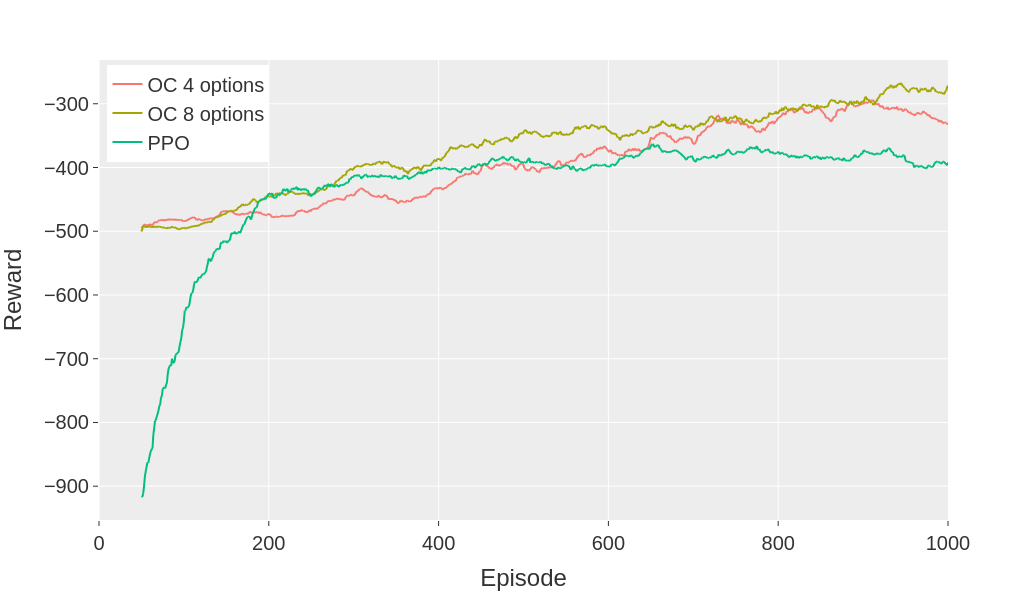

In [60]:
fig = monitor.plot(x="episode", y="reward", color="label", env="LTLtaxi", 
                   group=["env.name", "label"], 
                   rolling_mean=50, x_range=[0, 1000], exp_range=(1, 10), dpi=(2,2))
fig.write_image('taxi_curves.png')
fig

In [52]:
eval_data = pd.DataFrame()
names = monitor.configs[(monitor.configs["env.name"]=="LTLtaxi")&(monitor.configs["agent.name"]=="OC")].name.unique()

for name in names:
    eval_log = eval_model(name)
    eval_log["name"] = name
    eval_data = pd.concat([eval_data, eval_log])

OC_LTLtaxi_3_4opt
OC_LTLtaxi_3_4opt, Options: [4 2 3], Num Options: 4, Ep Steps: 201, Reward: -1
OC_LTLtaxi_4_8opt
OC_LTLtaxi_4_8opt, Options: [6], Num Options: 8, Ep Steps: 201, Reward: -1
OC_LTLtaxi_1_4opt
OC_LTLtaxi_1_4opt, Options: [2], Num Options: 4, Ep Steps: 201, Reward: -1
OC_LTLtaxi_7_4opt
OC_LTLtaxi_7_4opt, Options: [3], Num Options: 4, Ep Steps: 201, Reward: -1
OC_LTLtaxi_9_4opt
OC_LTLtaxi_9_4opt, Options: [4], Num Options: 4, Ep Steps: 1, Reward: -1
OC_LTLtaxi_5_8opt
OC_LTLtaxi_5_8opt, Options: [1], Num Options: 8, Ep Steps: 201, Reward: -1
OC_LTLtaxi_4_4opt
OC_LTLtaxi_4_4opt, Options: [2], Num Options: 4, Ep Steps: 1, Reward: -1
OC_LTLtaxi_6_4opt
OC_LTLtaxi_6_4opt, Options: [3 2], Num Options: 4, Ep Steps: 4, Reward: -1
OC_LTLtaxi_2_8opt
OC_LTLtaxi_2_8opt, Options: [8 1], Num Options: 8, Ep Steps: 201, Reward: -1
OC_LTLtaxi_3_8opt
OC_LTLtaxi_3_8opt, Options: [2 7], Num Options: 8, Ep Steps: 201, Reward: -1
OC_LTLtaxi_8_4opt
OC_LTLtaxi_8_4opt, Options: [3], Num Options: 4,

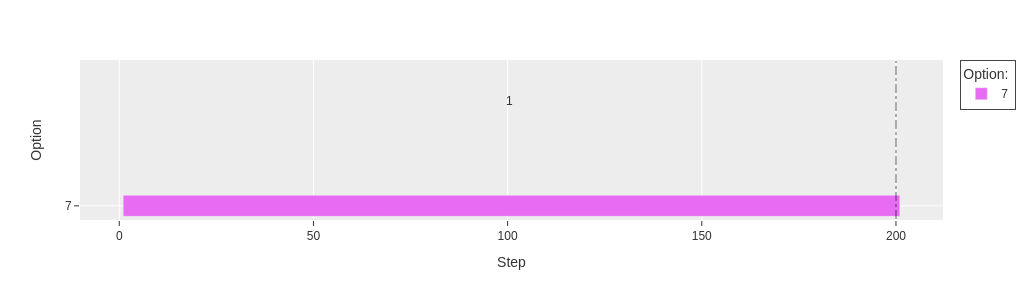

In [49]:
name = "OC_LTLtaxi_4_8opt"
# PARTITION OPTIONS
options_trace = eval_data[eval_data["name"]==name]["option_trace"]
options_partitions = get_partitions(options_trace)
## Fill for empty options
options_partitions = (
    options_partitions.sort_values("option")
    # .set_index("option")
    # .reindex(list(map(str, range(1, 8+1))))
    .reset_index()
)
# display(options_partitions)

# PARTITION SPEC STATE
spec_trace = eval_data[eval_data["name"]==name]["spec_trace"]
spec_partitions = get_partitions(spec_trace)
# display(spec_partitions)

fig = px.bar(
    options_partitions, base="start", x="duration", y="option", orientation='h', color="option",
    color_discrete_map = {str(i+1): matplotlib.colors.to_hex(colors[i]) for i in range(len(colors))},
    labels={"option":"Option", "duration": "Step"},
    template="ggplot2",
    width=3.5*DPI, height=1*DPI
)

text_cords = []
spec_text = [] 
for i, spec_idx in spec_partitions.iterrows():

    
    fig.add_shape(
        type="line",
        x0=spec_idx["end"], y0=-0.5, x1=spec_idx["end"], y1=5.5,
        line=dict(
            color="black",
            width=2,
            dash="dashdot",
        )
    )

    cord = (spec_idx["end"]-spec_idx["start"])/2 + spec_idx["start"]
    fig.add_annotation(
            x=cord, y=4,
            text=int(spec_idx["option"]) + 1,
            showarrow=False,
                      )
    text_cords.append(cord)
    spec_text.append(f"State {i + 1}")


fig.update_layout(
    legend=dict(
        title= {'text': "Option: "},
        borderwidth=1,
        # x=0.94,
        # y=0.54,
        yanchor="top",
        xanchor="left",  
        # font=dict(
        #     family="Courier",
        #     size=12,
        #     color="black"
        # ),
))